In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

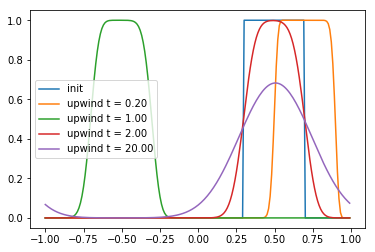

In [3]:
def initCond(profile):
    x = np.linspace(-1,1,M,endpoint=False)
    
    # test 1 - Toro 5.5.1
    if profile == 'smooth':
        alpha = 1.0
        beta = 8.0       
                
        u = alpha * np.exp(-beta*x**2.)
    
    # test 2 - discontinuous data
    elif profile == 'squarewave':
        u = a*np.ones_like(x)
        u[x <= 0.3] = 0.
        u[x >= 0.7] = 0.
    
    return x,u

def solve(x,u0,method,tend):
    
    # setup perodic boundary conditions
    u = np.zeros((u0.shape[0] + 2),u0.dtype)
    
    u[1:-1] = u0

    time = 0
    dx = x[1] - x[0]
    
    while time < tend:
        # periodic boundary cond.
        u[0] = u[-2]
        u[-1] = u[1]
        
        dt = cfl * dx / a
        
        # eq. (5.12)
        if method == 'FTCS':            
            u[1:-1] -= 0.5 * cfl * (u[2:] - u[:-2])
        
        # First order upwind / CIR: eq. (5.16)
        elif method == 'upwind':
            u[1:-1] -= cfl * (u[1:-1] - u[:-2])
                    
        else:
            print('method not implemented')
            return False
        
        time += dt
        if time + dt > tend:
            dt = tend - time
    return u[1:-1] 

def cmpSolversVsTimes(pattern,methods,tends):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for tend in tends:
        for method in methods:
            u = solve(x,u0,method,tend)
            plt.plot(x,u,label= "%s t = %.2f" % (method,tend))

    plt.legend()
    
a = 1.
cfl = 0.8
M = 200 

cmpSolversVsTimes('squarewave',[
    #'FTCS',
    'upwind',
    ], [0.2,1.0,2.0,20.0])

In [16]:
1+1

2

### Solver with 1 hard coded ghost zones and periodic BC

In [24]:
def solve(x,u0,method,tend):
    
    # setup perodic boundary conditions
    u = np.zeros((u0.shape[0] + 2),u0.dtype)
    
    u[1:-1] = u0

    time = 0
    dx = x[1] - x[0]
    
    while time < tend:
        # periodic boundary cond.
        u[0] = u[-2]
        u[-1] = u[1]
        
        dt = cfl * dx / a
        
        # eq. (5.12)
        if method == 'FTCS':            
            u[1:-1] -= 0.5 * cfl * (u[2:] - u[:-2])
        
        # First order upwind / CIR: eq. (5.16)
        elif method == 'upwind':
            u[1:-1] -= cfl * (u[1:-1] - u[:-2])
                    
        else:
            print('method not implemented')
            return False
        
        time += dt
        if time + dt > tend:
            dt = tend - time
    return u[1:-1]

In [25]:
def cmpSolversVsTimes(pattern,methods,tends):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for tend in tends:
        for method in methods:
            u = solve(x,u0,method,tend)
            plt.plot(x,u,label= "%s t = %.2f" % (method,tend))

    plt.legend()

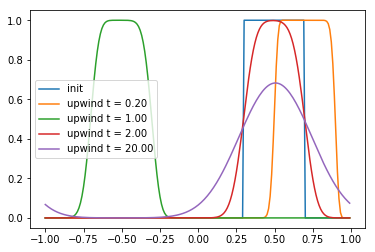

In [26]:
a = 1.
cfl = 0.8
M = 200 

cmpSolversVsTimes('squarewave',[
    #'FTCS',
    'upwind',
    ], [0.2,1.0,2.0,20.0])

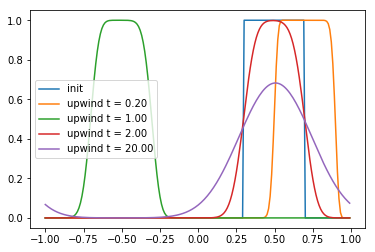

In [18]:
cmpSolversVsTimes('squarewave',[
    #'FTCS',
    'upwind',
    ], [0.2,1.0,2.0,20.0])

method not implemented


ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

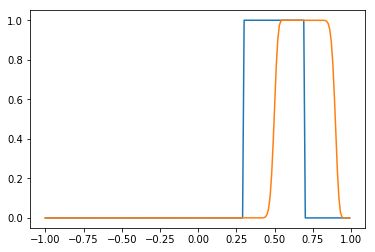

In [17]:
cmpSolversVsTimes('squarewave',[
    #'FTCS',
    'upwind',
    #'LF'
    ], [0.2,1.0,2.0,20.0])

In [3]:
def solve(x,u0,method,tend):
    
    # setup perodic boundary conditions
    u = np.zeros((u0.shape[0] + 2),u0.dtype)
    
    u[1:-1] = u0

    time = 0
    dx = x[1] - x[0]
    
    while time < tend:
        # periodic boundary cond.
        u[0] = u[-2]
        u[-1] = u[1]
        
        dt = cfl * dx / a
        c = dt * a / dx
        
        # eq. (5.12)
        if method == 'FTCS':            
            u[1:-1] -= 0.5 * c * (u[2:] - u[:-2])
        
        # First order upwind / CIR: eq. (5.16)
        elif method == 'upwind':
            u[1:-1] -= c * (u[1:-1] - u[:-2])
        
        # Lax Friedrichs: eq. (5.30)
        elif method == 'LF':
            u[1:-1] = 0.5*(1. + c) * u[:-2] + 0.5 * (1. - c) * u[2:]
            
        # Lax-Wendroff (2nd order): eq. (5.34) 
        elif method == 'LW':
            u[1:-1] = (0.5*c*(1. + c) * u[:-2] + 
                       (1 - c**2.) * u[1:-1] - 
                       0.5 * c*(1. - c) * u[2:])
                    
        else:
            print('method not implemented')
            return False
        
        time += dt
        if time + dt > tend:
            dt = tend - time
    return u[1:-1]

### Solver with dynamic ghost zones and periodic BC

In [3]:
def solve(x,u0,method,tend):
    
    if method == 'BW':
        NGhost = 2
    else:
        NGhost = 1
        
    
    # number of grid points without the ghost zones
    N = u0.shape[0]
    
    # larger array to account for ghost zones
    u = np.zeros((N + 2 * NGhost),u0.dtype)
    
    u[NGhost:-NGhost] = u0

    time = 0
    dx = x[1] - x[0]
    
    while time < tend:
        
        # use views to variable for better readability
        # these don't allocate additional memory
        u_i = u[NGhost:-NGhost]
        u_ip1 = u[NGhost+1:NGhost+1+N]
        u_im1 = u[NGhost-1:NGhost-1+N]        
        
        # periodic boundary cond.        
        if NGhost == 1:            
            u[0] = u[-2]
            u[-1] = u[1]
        elif NGhost == 2:
            u[0] = u[-4]
            u[1] = u[-3]
            u[-2] = u[0]
            u[-1] = u[1]
            
            u_ip2 = u[NGhost+2:NGhost+2+N]
            u_im2 = u[NGhost-2:NGhost-2+N] 
                
        else:
            print("FAIL - NGhost = %d not implemented yet." % NGhost)
            return False
        
        dt = cfl * dx / np.abs(a)
        c = dt * a / dx
        
        # eq. (5.12)
        if method == 'FTCS':            
            u_i -= 0.5 * c * (u_ip1 - u_im1)
        
        # First order upwind / CIR: eq. (5.16)
        elif method == 'upwind':
            u_i -= c * (u_i - u_im1)
        
        # Lax Friedrichs: eq. (5.30)
        elif method == 'LF':            
            u_i[:] = 0.5*(1. + c) * u_im1 + 0.5 * (1. - c) * u_ip1            
            
        # Lax-Wendroff (2nd order): eq. (5.34) 
        elif method == 'LW':
            u_i[:] = (0.5*c*(1. + c) * u_im1 + 
                       (1 - c**2.) * u_i - 
                       0.5 * c*(1. - c) * u_ip1)
        # Beam Warming (2nd order - on sided): eq. (5.35)
        elif method == 'BW':
            u_i[:] = (0.5*c*(c-1.) * u_im2 +
                      c*(2. - c) * u_im1 + 
                      0.5*(c-1.)*(c-2.)*u_i)
            
            
        
        else:
            print('method not implemented')
            return False
        
        time += dt
        if time + dt > tend:
            dt = tend - time
    return u_i
        
    
    
    

In [5]:
def cmpSolvers(pattern,methods,tend):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for method in methods:
        u = solve(x,u0,method,tend)
        plt.plot(x,u,label=method)

    plt.legend()

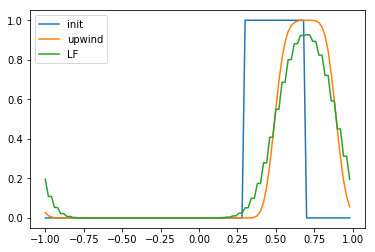

In [13]:
a = 1.
cfl = 0.3
M = 100 

cmpSolvers('squarewave',[
    ##'FTCS',
    'upwind',
    'LF',
    #'LW',
    #'BW',
    ], 0.2)

In [20]:
def cmpSolversVsTimes(pattern,methods,tends):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for tend in tends:
        for method in methods:
            u = solve(x,u0,method,tend)
            plt.plot(x,u,label= "%s t = %.2f" % (method,tend))

    plt.legend()

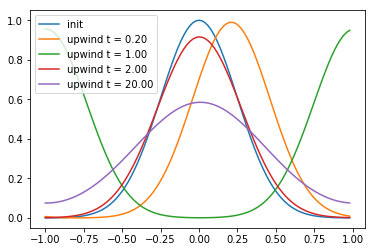

In [23]:
cmpSolversVsTimes('smooth',[
    ##'FTCS',
    'upwind',
    #'LF',
    #'LW',
    #'BW',
    ], [0.2,1.0,2.0,20.0])

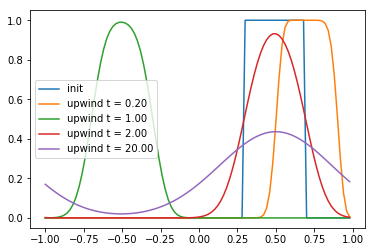

In [24]:
cmpSolversVsTimes('squarewave',[
    ##'FTCS',
    'upwind',
    #'LF',
    #'LW',
    #'BW',
    ], [0.2,1.0,2.0,20.0])

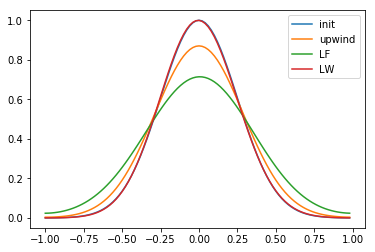

In [28]:
cmpSolvers('smooth',[#'FTCS',
                     'upwind',
                     'LF',
                     'LW',
                    ], 20.0)

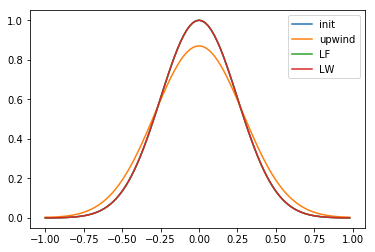

In [7]:


#x, u0 = initCond('squarewave')
x, u0 = initCond('smooth')
plt.plot(x,u0,label='init')

u = solve(x,u0,'FTCS',2.0)
#plt.plot(x,u,label='FTCS')

u = solve(x,u0,'upwind',2.0)
plt.plot(x,u,label='upwind')

u = solve(x,u0,'LF',2.0)
plt.plot(x,u,label='LF')

u = solve(x,u0,'LW',2.0)
plt.plot(x,u,label='LW')


plt.legend()

In [63]:
x[u == np.max(u)]

array([0.])

## nonlinear

done 19 steps
done 19 steps


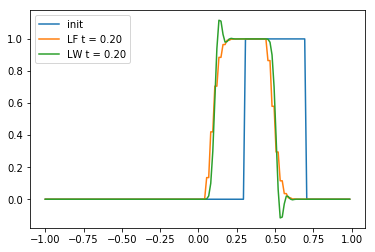

In [40]:
def initCond(profile):
    
    
    # test 1 - Toro 5.5.1
    if profile == 'smooth':
        x = np.linspace(-1,1,M,endpoint=False)
        alpha = 1.0
        beta = 8.0       
                
        u = alpha * np.exp(-beta*x**2.)
    
    # test 2 - discontinuous data
    elif profile == 'squarewave':
        x = np.linspace(-1,1,M,endpoint=False)
        u = 1.*np.ones_like(x)
        u[x <= 0.3] = 0.
        u[x >= 0.7] = 0.
    
    elif profile == 'burgers':
        x = np.linspace(0,1.5,M,endpoint=False)
        u = np.ones_like(x)
        u[x <= 0.5] = -0.5
        u[x >= 1.] = 0.
    
    return x,u

def getFlux(u):
    if eqn == 'linear':
        return a*u
    elif eqn == 'burgers':
        return 0.5*u**2.
    else:
        return False


def solve(x,u0,method,tend):
        
    # setup perodic boundary conditions
    u = np.zeros((u0.shape[0] + 2),u0.dtype)
    
    u[1:-1] = u0

    time = 0
    dx = x[1] - x[0]
    steps = 0
    
    while time < tend:
        # periodic boundary cond.
        u[0] = u[-2]
        u[-1] = u[1]
        
        if eqn == 'linear':
            dt = cfl * dx / np.abs(a)
        elif eqn == 'burgers':
            dt = cfl * dx / np.max(np.abs(u))
        else:
            return False            
        
        
        # eq. (5.12)
        if method == 'FTCS':            
            u[1:-1] -= 0.5 * cfl * (u[2:] - u[:-2])
        
        # First order upwind / CIR: eq. (5.16)
        elif method == 'upwind':
            u[1:-1] -= cfl * (u[1:-1] - u[:-2])
        # Lax Friedrichs: eq. (5.30)
        elif method == 'LF':            
            #u_i[:] = 0.5*(1. + c) * u_im1 + 0.5 * (1. - c) * u_ip1 
            
            #FLF_imoh = 0.5*(getFlux(u[:-2]) + getFlux(u[1:-1])) + 0.5*dx/dt*(u[:-2] - u[1:-1])
            #FLF_ipoh = 0.5*(getFlux(u[1:-1]) + getFlux(u[2:])) + 0.5*dx/dt*(u[1:-1] - u[2:])
            #u[1:-1] += dt/dx * (FLF_imoh - FLF_ipoh)
            
            # Toro (5.77) 
            FLF = 0.5*(getFlux(u[:-1]) + getFlux(u[1:])) + 0.5*dx/dt*(u[:-1] - u[1:])
            # Toro (5.76)
            u[1:-1] += dt/dx * (FLF[:-1] - FLF[1:])
        elif method == 'LW':
            
            U_ipoh_npoh = 0.5*(u[:-1] + u[1:]) + 0.5 * dt/dx * (getFlux(u[:-1] - u[1:]))
            FLW = getFlux(U_ipoh_npoh)
            u[1:-1] += dt/dx * (FLW[:-1] - FLW[1:])
        
        elif method == 'WAF':
            
                    
        else:
            print('method not implemented')
            return False
        
        time += dt
        if time + dt > tend:
            dt = tend - time
        steps += 1
    print("done %d steps" % steps)
    return u[1:-1] 

def cmpSolversVsTimes(pattern,methods,tends):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for tend in tends:
        for method in methods:
            u = solve(x,u0,method,tend)
            plt.plot(x,u,label= "%s t = %.2f" % (method,tend))

    plt.legend()
    
a = -1.
cfl = 0.8
M = 150
eqn = 'linear'


cmpSolversVsTimes('squarewave',[
    #'FTCS',
    'LF',
    'LW'
    ], [0.2])

done 1876 steps
done 1876 steps


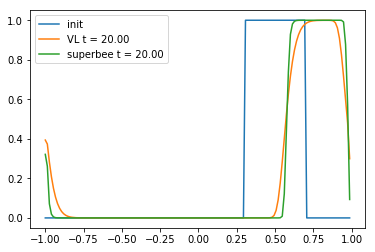

In [67]:
def initCond(profile):
    
    
    # test 1 - Toro 5.5.1
    if profile == 'smooth':
        x = np.linspace(-1,1,M,endpoint=False)
        alpha = 1.0
        beta = 8.0       
                
        u = alpha * np.exp(-beta*x**2.)
    
    # test 2 - discontinuous data
    elif profile == 'squarewave':
        x = np.linspace(-1,1,M,endpoint=False)
        u = 1.*np.ones_like(x)
        u[x <= 0.3] = 0.
        u[x >= 0.7] = 0.
    
    elif profile == 'burgers':
        x = np.linspace(0,1.5,M,endpoint=False)
        u = np.ones_like(x)
        u[x <= 0.5] = -0.5
        u[x >= 1.] = 0.
    
    return x,u

def solve(x,u0,method,tend):
        
    # setup perodic boundary conditions
    u = np.zeros((u0.shape[0] + 2),u0.dtype)
    
    u[1:-1] = u0

    time = 0
    dx = x[1] - x[0]
    steps = 0
    
    while time < tend:
        # periodic boundary cond.
        u[0] = u[-4]
        u[1] = u[-3]
        u[-2] = u[2]
        u[-1] = u[3]
        
        dt = c * dx / np.abs(a)
        
        if time + dt > tend:
            dt = tend - time
         
        u_i = u[2:-2]
        u_ip1 = u[3:-1]
        u_im1 = u[-1:-3]

                 
        alpha0 = 1.
        alpha1 = 0.
        beta0 = 0.5 * (1 + c)
        beta1 = 0.5 * (1 - c)

        # doing DeltaU in one step (and using slices in the updates)
        #DeltaU_imoh = u_i - u_im1
        #DeltaU_ipoh = u_ip1 - u_i
        DeltaU = u[1:] - u[:-1]           

        # r is ratio of successive gradients (upwind/local)
        r = np.zeros_like(DeltaU[1:])
        mask = DeltaU[1:] != 0.
        r[mask] = DeltaU[:-1][mask]/DeltaU[1:][mask]

        psi = np.zeros_like(r)
        
        if method == 'VL':
            #Van Leer
            psi[r > 0] = 2*r[r > 0]/(1+r[r > 0])
        elif method == 'superbee':
            mask = np.logical_and(0 < r,r < 0.5)
            psi[mask] = 2*r[mask]
            mask = np.logical_and(0.5 < r , r < 1)
            psi[mask] = 1.
            mask = np.logical_and(1 < r , r < 2)
            psi[mask] = r[mask]
            psi[r>2] = 2.
            
        else:
            print('method not implemented')
            return False

        #### (13.137) TVD general flux limiter update 
        C = c * (alpha0 + (beta0 - alpha0) * psi[:-2])
        D = -c * (alpha1 + (beta1 - alpha1) * psi[1:-1])            

        u[2:-2] += -C * DeltaU[1:-2] + D * DeltaU[2:-1]
            
                    

        
        time += dt

        steps += 1
    print("done %d steps" % steps)
    return u[1:-1] 

def cmpSolversVsTimes(pattern,methods,tends):
    x, u0 = initCond(pattern)
    plt.plot(x,u0,label='init')    
    
    for tend in tends:
        for method in methods:
            u = solve(x,u0,method,tend)
            plt.plot(x,u,label= "%s t = %.2f" % (method,tend))

    plt.legend()
    
a = 1.
c = 0.8
M = 150

cmpSolversVsTimes('squarewave',[
    'VL',
    'superbee',
    #'LF',
    #'LW'
    ], [20.0])